# Minimal Working Example for scGPT

How to install: follow the instructions [here](https://medium.com/@xuer.chen.human/a-step-by-step-guide-to-install-scgpt-79df167a64e3)


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings

sys.path.insert(0, "../../")
import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [5]:
model_dir     = Path("/nfs/turbo/umms-indikar/shared/projects/foundation_models/scGPT_human")
adata         = sc.read_h5ad("/nfs/turbo/umms-indikar/shared/projects/foundation_models/example_inputs/annotation_pancreas/demo_train.h5ad")
cell_type_key = "Celltype"
gene_col      = "index"

In [39]:
# input_file = '/nfs/turbo/umms-indikar/shared/projects/geneformer/data/mitoticExit.h5ad'
input_file = '/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data_jpic.h5ad'
adata      = sc.read_h5ad(input_file)
cell_type_key = list(adata.obs.columns)
gene_col   = "gene_name"

In [40]:
adata

AnnData object with n_obs × n_vars = 66 × 19393
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control', 'order', 'replicate', 'batch'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id'

In [42]:
adata.var['gene_name'] = adata.var.index
adata = adata[adata.obs['dataset'] == 'liu_2018', :]
adata

View of AnnData object with n_obs × n_vars = 48 × 19393
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control', 'order', 'replicate', 'batch'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id'

In [43]:
adata.var['gene_name'] = adata.var.index

/tmp/ipykernel_65312/2897097408.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_name'] = adata.var.index


In [44]:
adata.obs

,dataset,sample_id,timepoint,hour,n_counts,control,order,replicate,batch
data_id,,,,,,,,,
63246_T0R1,liu_2018,63246,1.0,-48.0,11940999,True,0,1,1
63252_T1R1,liu_2018,63252,2.0,0.0,18063509,False,1,1,1
63249_T2R1,liu_2018,63249,3.0,8.0,11031474,False,2,1,1
63261_T3R1,liu_2018,63261,1.0,16.0,16761043,False,3,1,1
63258_T4R1,liu_2018,63258,2.0,24.0,8244802,False,4,1,1
63255_T5R1,liu_2018,63255,3.0,32.0,10615057,False,5,1,1
63270_T6R1,liu_2018,63270,1.0,40.0,16486670,False,6,1,1
63267_T7R1,liu_2018,63267,2.0,48.0,10127547,False,7,1,1
63264_T8R1,liu_2018,63264,3.0,56.0,11231585,False,8,1,1


In [45]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 19267/19393 genes in vocabulary of size 60697.


/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [46]:
ref_embed_adata.write('/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/populationReprogramming/scgpt.h5ad')

In [37]:
ref_embed_adata.X.shape

(18, 512)

In [9]:
adata.var

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf,ensembl_id,ref
gene_name_raw,,,,,,,,,,,,
A1BG-AS1__chr19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Time-resolved single-cell sequencing identifie...
A1BG__chr19,ENSG00000121410,5150.0,A1BG,1.9014707072869992,12.0,protein_coding,19,58345177.0,58353492.0,False,ENSG00000121410,Time-resolved single-cell sequencing identifie...
A1CF__chr10,ENSG00000148584,9064.0,A1CF,5.672082623303387,15.0,protein_coding,10,50799408.0,50885675.0,False,ENSG00000148584,Time-resolved single-cell sequencing identifie...
A2M-AS1__chr12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Time-resolved single-cell sequencing identifie...
A2ML1__chr12,ENSG00000166535,11812.0,A2ML1,3.6480213241038815,20.0,protein_coding,12,8822620.0,8887001.0,False,ENSG00000166535,Time-resolved single-cell sequencing identifie...
...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A__chr1,ENSG00000203995,17515.0,ZYG11A,2.03536539076206,10.0,protein_coding,1,52842510.0,52894998.0,False,ENSG00000203995,Time-resolved single-cell sequencing identifie...
ZYG11B__chr1,ENSG00000162378,10655.0,ZYG11B,3.3388216887076494,13.0,protein_coding,1,52726452.0,52827336.0,False,ENSG00000162378,Time-resolved single-cell sequencing identifie...
ZYX__chr7,ENSG00000159840,10336.0,ZYX,2.8625192615652857,16.0,protein_coding,7,143381294.0,143391111.0,False,ENSG00000159840,Time-resolved single-cell sequencing identifie...


In [7]:
adata.var

,Gene Symbol,index,id_in_vocab
COL1A1,COL1A1,COL1A1,5325
COL1A2,COL1A2,COL1A2,5326
PPY,PPY,PPY,20184
CTRB1,CTRB1,CTRB1,7139
CELA3A,CELA3A,CELA3A,4605
...,...,...,...
FAM110D,FAM110D,FAM110D,8864
SELL,SELL,SELL,30881
C9orf135,C9orf135,C9orf135,3746
GRIN2D,GRIN2D,GRIN2D,10473


In [7]:
adata.X

array([[0.        , 0.        , 1.024161  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7810583 , ..., 0.        , 0.        ,
        0.        ],
       [0.4174824 , 0.        , 0.7111194 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.7314659 , 0.7314659 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6049162 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [5.065183  , 3.7353158 , 0.        , ..., 0.        , 0.        ,
        0.17877471]], dtype=float32)

In [5]:
ref_embed_adata

AnnData object with n_obs × n_vars = 10600 × 512
    obs: 'Celltype'

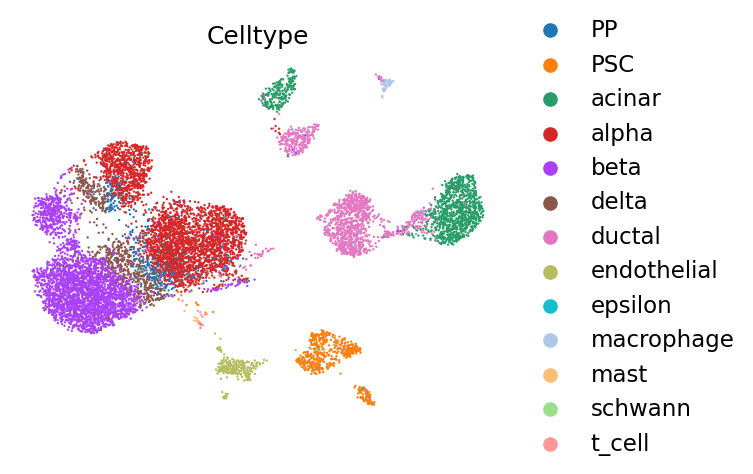

In [6]:
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

# Annotation Tutorial

## Step 1: Set up and parameters

In [1]:
# %%
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

[rank: 0] Global seed set to 0
/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jpic/.conda/envs/scgpt3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [15]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="ms",
    do_train=True,
    load_model="/nfs/turbo/umms-indikar/shared/projects/foundation_models/scGPT_human",
    mask_ratio=0.0,
    epochs=10,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [16]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

{'seed': 0, 'dataset_name': 'ms', 'do_train': True, 'load_model': '/nfs/turbo/umms-indikar/shared/projects/foundation_models/scGPT_human', 'mask_ratio': 0.0, 'epochs': 10, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False}


In [17]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

In [18]:
# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

In [19]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_ms-Jul10-23-51


## Step 2: Load data (not working)

In [20]:
if dataset_name == "ms":
    data_dir = Path("/home/jpic/scFoundationProject/scGPT/scGPT/data/ms")
    adata = sc.read(data_dir / "c_data.h5ad")
    adata_test = sc.read(data_dir / "filtered_ms_adata.h5ad")
    adata.obs["celltype"] = adata.obs["Factor Value[inferred cell type - authors labels]"].astype("category")
    adata_test.obs["celltype"] = adata_test.obs["Factor Value[inferred cell type - authors labels]"].astype("category")
    adata.obs["batch_id"]  = adata.obs["str_batch"] = "0"
    adata_test.obs["batch_id"]  = adata_test.obs["str_batch"] = "1"          
    adata.var.set_index(adata.var["gene_name"], inplace=True)
    adata_test.var.set_index(adata.var["gene_name"], inplace=True)
    data_is_raw = False
    filter_gene_by_counts = False
    adata_test_raw = adata_test.copy()
    adata = adata.concatenate(adata_test, batch_key="str_batch")
                
# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))
adata.obs["celltype_id"] = celltype_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

In [21]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

scGPT - INFO - match 2808/3000 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from /nfs/turbo/umms-indikar/shared/projects/foundation_models/scGPT_human/best_model.pt, the model args will override the config /nfs/turbo/umms-indikar/shared/projects/foundation_models/scGPT_human/args.json.


In [36]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)


adata_test = adata[adata.obs["str_batch"] == "1"]
adata = adata[adata.obs["str_batch"] == "0"]

preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...


AttributeError: 'csr_matrix' object has no attribute 'A'

In [25]:
from scanpy.get import _get_obs_rep, _set_obs_rep

In [29]:
_get_obs_rep(adata)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2171412 stored elements and shape (7844, 2808)>

In [31]:
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))

## Step 3: Load Model

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

# Freeze all pre-decoder weights
for name, para in model.named_parameters():
    print("-"*20)
    print(f"name: {name}")
    if config.freeze and "encoder" in name and "transformer_encoder" not in name:
    # if config.freeze and "encoder" in name:
        print(f"freezing weights for: {name}")
        para.requires_grad = False

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")
wandb.log(
        {
            "info/pre_freeze_param_count": pre_freeze_param_count,
            "info/post_freeze_param_count": post_freeze_param_count,
        },
)

model.to(device)
wandb.watch(model)

if ADV:
    discriminator = AdversarialDiscriminator(
        d_model=embsize,
        n_cls=num_batch_types,
    ).to(device)


scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Si

In [33]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, schedule_interval, gamma=config.schedule_ratio
)
if DAB_separate_optim:
    optimizer_dab = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler_dab = torch.optim.lr_scheduler.StepLR(
        optimizer_dab, schedule_interval, gamma=config.schedule_ratio
    )
if ADV:
    criterion_adv = nn.CrossEntropyLoss()  # consider using label smoothing
    optimizer_E = torch.optim.Adam(model.parameters(), lr=lr_ADV)
    scheduler_E = torch.optim.lr_scheduler.StepLR(
        optimizer_E, schedule_interval, gamma=config.schedule_ratio
    )
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_ADV)
    scheduler_D = torch.optim.lr_scheduler.StepLR(
        optimizer_D, schedule_interval, gamma=config.schedule_ratio
    )

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [34]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    (
        total_loss,
        total_mse,
        total_cls,
        total_cce,
        total_mvc,
        total_ecs,
        total_dab,
        total_adv_E,
        total_adv_D,
        total_zero_log_prob,
        total_mvc_zero_log_prob,
    ) = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    total_error = 0.0
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        celltype_labels = batch_data["celltype_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
                do_sample=do_sample_in_train,
                #generative_training=False
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = 0.0
            metrics_to_log = {}
            if MLM:
                loss_mse = criterion(
                    output_dict["mlm_output"], target_values, masked_positions
                )
                loss = loss + loss_mse
                metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if CLS:
                loss_cls = criterion_cls(output_dict["cls_output"], celltype_labels)
                loss = loss + loss_cls
                metrics_to_log.update({"train/cls": loss_cls.item()})

                error_rate = 1 - (
                    (output_dict["cls_output"].argmax(1) == celltype_labels)
                    .sum()
                    .item()
                ) / celltype_labels.size(0)
            if CCE:
                loss_cce = 10 * output_dict["loss_cce"]
                loss = loss + loss_cce
                metrics_to_log.update({"train/cce": loss_cce.item()})
            if MVC:
                loss_mvc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_mvc
                metrics_to_log.update({"train/mvc": loss_mvc.item()})
            if MVC and explicit_zero_prob:
                loss_mvc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_mvc_zero_log_prob
                metrics_to_log.update({"train/mvc_nzlp": loss_mvc_zero_log_prob.item()})
            if ECS:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            if DAB:
                # try weighting and separate optimizer
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
                loss = loss + dab_weight * loss_dab
                metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        if ADV:
            # rerun the model for adversarial training
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
                do_sample=do_sample_in_train,
                #generative_training=False
            )

            # TRAINING DISCRIMINATOR
            loss_adv_D = criterion_adv(
                discriminator(output_dict["cell_emb"].detach()), batch_labels
            )
            if epoch > adv_D_delay_epochs:
                discriminator.zero_grad()
                loss_adv_D.backward()
                optimizer_D.step()

            # TRAINING ENCODER
            loss_adv_E = -criterion_adv(
                discriminator(output_dict["cell_emb"]), batch_labels
            )
            # NOTE: the loss is negative here because we want to maximize
            # the cross_entropy_loss, in other words, disguise against the discriminator
            if epoch > adv_E_delay_epochs:
                model.zero_grad()
                discriminator.zero_grad()
                loss_adv_E.backward()
                optimizer_E.step()

        wandb.log(metrics_to_log)

        total_loss += loss.item()
        total_mse += loss_mse.item() if MLM else 0.0
        total_cls += loss_cls.item() if CLS else 0.0
        total_cce += loss_cce.item() if CCE else 0.0
        total_mvc += loss_mvc.item() if MVC else 0.0
        total_ecs += loss_ecs.item() if ECS else 0.0
        total_dab += loss_dab.item() if DAB else 0.0
        total_adv_E += loss_adv_E.item() if ADV else 0.0
        total_adv_D += loss_adv_D.item() if ADV else 0.0
        total_zero_log_prob += loss_zero_log_prob.item() if explicit_zero_prob else 0.0
        total_mvc_zero_log_prob += (
            loss_mvc_zero_log_prob.item() if MVC and explicit_zero_prob else 0.0
        )
        total_error += error_rate
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_cls = total_cls / log_interval if CLS else 0.0
            cur_cce = total_cce / log_interval if CCE else 0.0
            cur_mvc = total_mvc / log_interval if MVC else 0.0
            cur_ecs = total_ecs / log_interval if ECS else 0.0
            cur_dab = total_dab / log_interval if DAB else 0.0
            cur_adv_E = total_adv_E / log_interval if ADV else 0.0
            cur_adv_D = total_adv_D / log_interval if ADV else 0.0
            cur_zero_log_prob = (
                total_zero_log_prob / log_interval if explicit_zero_prob else 0.0
            )
            cur_mvc_zero_log_prob = (
                total_mvc_zero_log_prob / log_interval
                if MVC and explicit_zero_prob
                else 0.0
            )
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | "
                + (f"mse {cur_mse:5.2f} | mre {cur_error:5.2f} |" if MLM else "")
                + (f"cls {cur_cls:5.2f} | " if CLS else "")
                + (f"err {cur_error:5.2f} | " if CLS else "")
                + (f"cce {cur_cce:5.2f} |" if CCE else "")
                + (f"mvc {cur_mvc:5.2f} |" if MVC else "")
                + (f"ecs {cur_ecs:5.2f} |" if ECS else "")
                + (f"dab {cur_dab:5.2f} |" if DAB else "")
                + (f"adv_E {cur_adv_E:5.2f} |" if ADV else "")
                + (f"adv_D {cur_adv_D:5.2f} |" if ADV else "")
                + (f"nzlp {cur_zero_log_prob:5.2f} |" if explicit_zero_prob else "")
                + (
                    f"mvc_nzlp {cur_mvc_zero_log_prob:5.2f} |"
                    if MVC and explicit_zero_prob
                    else ""
                )
            )
            total_loss = 0
            total_mse = 0
            total_cls = 0
            total_cce = 0
            total_mvc = 0
            total_ecs = 0
            total_dab = 0
            total_adv_E = 0
            total_adv_D = 0
            total_zero_log_prob = 0
            total_mvc_zero_log_prob = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    predictions = []
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)
            celltype_labels = batch_data["celltype_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                    CLS=CLS,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=do_sample_in_train,
                    #generative_training = False,
                )
                output_values = output_dict["cls_output"]
                loss = criterion_cls(output_values, celltype_labels)

                if DAB:
                    loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            accuracy = (output_values.argmax(1) == celltype_labels).sum().item()
            total_error += (1 - accuracy / len(input_gene_ids)) * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids) if DAB else 0.0
            total_num += len(input_gene_ids)
            preds = output_values.argmax(1).cpu().numpy()
            predictions.append(preds)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/err": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + dab_weight * total_dab) / total_num,
            "epoch": epoch,
        },
    )

    if return_raw:
        return np.concatenate(predictions, axis=0)

    return total_loss / total_num, total_error / total_num


In [35]:
model

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el